## How to get your own data into PyTorch?

One of the ways is to do so via custom datasets

## Domain libraries
Depending on what you are working on, vision, text, audio etc look into each of the PyTorch domain libraries for existing data loading functions and customisable data loading functions




In [86]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [87]:
# Device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

# Get Data

Dataset is a subset of Food101 Dataset

Food101 starts with 101 classes amd 1000 images per class (750 training, 250 testing)

but we start with 3 classes now and only 10% of the images (75 training, 25 testing per class) to speed up our experimentation at the beginning

In [4]:
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If directory doesnt exist
if image_path.is_dir():
  print("Already exists")
else:
  print("Creating directory")
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading data...")
  f.write(request.content)

# Unzip data file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)


Creating directory
Unzipping data...


In [5]:
data_path, image_path

(PosixPath('data'), PosixPath('data/pizza_steak_sushi'))

## Becoming one with the data

In [6]:
import os
def walk_through_dir(dir_path):
  """Walks through the path returning its contents """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [8]:
# Set up train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

In [9]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualise an image
1. Get all image paths
2. Use random.choice() to choose random image
3. Get image class name using `pathlib.Path.parent.stem`
4. Use Python's PIL to open the image
5. Show image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/2821048.jpg
Image class: pizza
Image height: 512
Image width: 512


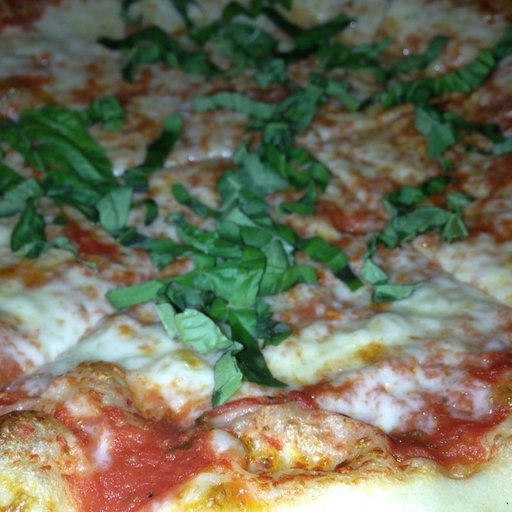

In [10]:
import random
from PIL import Image

# Set seed
random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # stick together all the files with a certain pattern, * means anything (to select all)

# Select random image
random_image_path = random.choice(image_path_list)

# Image clas is the name of the dir where the image is stored
image_class = random_image_path.parent.stem

# Open the image
img = Image.open(random_image_path)

# Print the metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

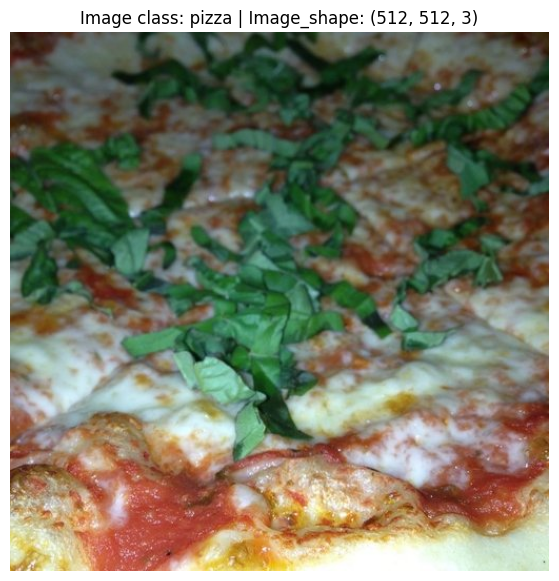

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into np array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image_shape: {img_as_array.shape}") # Height, width, colour channels, default for pil and np
# for pytorch its colour channels first
plt.axis(False);

In [12]:
img_as_array

array([[[ 67,  51,  38],
        [ 67,  51,  38],
        [ 65,  47,  33],
        ...,
        [ 49,  33,   8],
        [ 47,  29,   7],
        [ 45,  27,   5]],

       [[ 65,  49,  36],
        [ 66,  50,  37],
        [ 65,  47,  33],
        ...,
        [ 51,  35,  10],
        [ 50,  32,  10],
        [ 48,  30,   8]],

       [[ 60,  44,  31],
        [ 62,  46,  33],
        [ 63,  45,  31],
        ...,
        [ 53,  37,  12],
        [ 53,  35,  13],
        [ 52,  34,  12]],

       ...,

       [[191, 147,  38],
        [183, 141,  33],
        [185, 141,  42],
        ...,
        [208, 231, 202],
        [210, 234, 202],
        [211, 235, 203]],

       [[207, 161,  50],
        [182, 138,  31],
        [176, 130,  32],
        ...,
        [209, 232, 203],
        [207, 231, 199],
        [207, 231, 199]],

       [[210, 164,  52],
        [191, 144,  36],
        [181, 135,  37],
        ...,
        [210, 233, 204],
        [205, 229, 197],
        [203, 227, 195]]

## Transform all the data

1. Get into tensor format (numerical representation of images)
2. turn into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Transform data with torchvision.transform

- Change to tensors ready to be used with a model

In [14]:
# Write a transform for image
data_transform = transforms.Compose([ # similar to nn.Sequental()
    # Resize our images to 64x64 --> later can use tinyVGG
    transforms.Resize(size=(64, 64)),

    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # 50% of the images that go through will be flipped on horizontal axis

    # Turn image in torch tensor
    transforms.ToTensor()  # Convert PIL image or numpy array to tensor (H x W x C) to (C x H x W) in range 0 to 1
])

In [15]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [16]:
data_transform(img).dtype

torch.float32

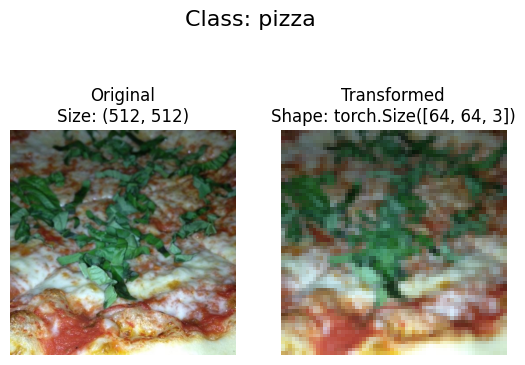

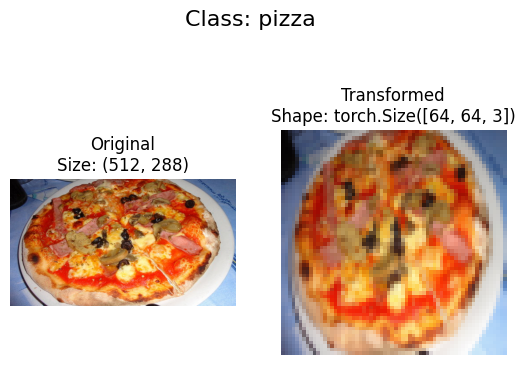

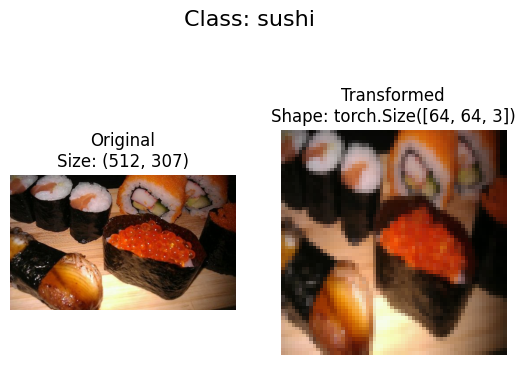

In [17]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them and plots the original vs
  the transformed version

  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n) # returns a list

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # need change back shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)


## Option 1: Loading image data using `ImageFolder`

Can load image classification data using `torchvision.datasets.ImageFolder`

torchvision.datasets have pre-built datasets function (to load custom data) just like there are pre-built datasets

In [18]:
# Use ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None) # transform for the target labels but we can infer from the directory

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [19]:
train_dir, train_data

(PosixPath('data/pizza_steak_sushi/train'),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
test_dir, test_data

(PosixPath('data/pizza_steak_sushi/test'),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [21]:
# Get class names as a a list
class_names = train_data.classes

class_names

['pizza', 'steak', 'sushi']

In [22]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [25]:
# Index on the train_data Dataset to get simgle image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64])
New shape: torch.Size([64, 64, 3])


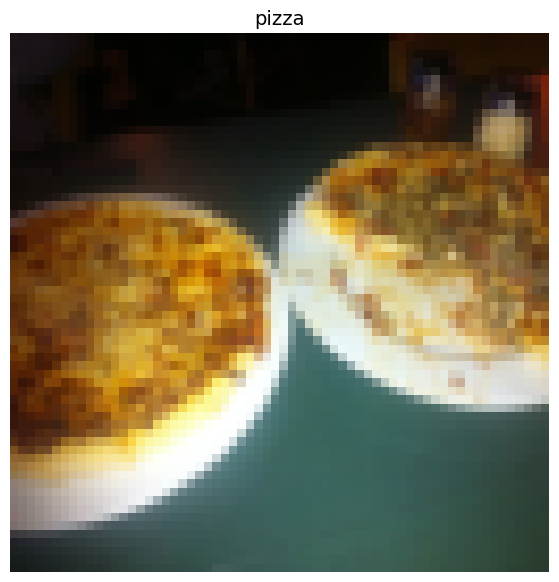

In [26]:
# Rearrange order of dimensions again
img_permute = img.permute(1, 2, 0)

# Print out the shapes
print(f"Original shape: {img.shape}")
print(f"New shape: {img_permute.shape}")



# plot
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14);

# Turn datasets into dataloaders (iterables and batchify data)

A `DataLoader` will turn `Dataset`s into iterables and we can customise
the batch_size so the model can see a batch_size at a time

In [27]:
import os
os.cpu_count()

2

In [28]:
## Turn train and test datasets into DataLoader's

from torch.utils.data import DataLoader

BATCH_SIZE=1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [29]:
train_dataloader

In [30]:
test_dataloader

In [31]:
len(train_dataloader) # 225 since batchsize of 1 so len same as the dataset

225

In [32]:
len(test_dataloader)

75

In [33]:
img, label = next(iter(train_dataloader))

# Batch size is 1
img.shape # batch_size, colour_channels, height, width

torch.Size([1, 3, 64, 64])

In [34]:
label.shape

torch.Size([1])

## Now imagine we do not have a prebuilt dataset helper like ImageFolder

Option 2: Loading image data with a custom `Dataset`
1. Need to be able to load images
2. Get class names
3. Get classes as dictionary

Pros:
* Can make a `Dataset` out of almost anything

* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even if you create `Dataset` out of almost anything it does not always work

* Need to write more code which could be prone to errors or performance issues

In [35]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset # base dataset class representing a dataset, need to subclass this
from torchvision import transforms
from typing import Tuple, Dict, List # type hints

In [36]:
# Instance of torchvision.datasets.ImageFolder(), need to replicate
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# Creating a helper function

We want a function to:
1. Get class name using `os.scandir()` to traverse a target directory (ideally the data is in standard image classification format)

2. Raise an error if class names not found

3. Turn class names into a dict and a list and return them

In [37]:
# Setup path for target dir
target_directory = train_dir
print(f"Target dir: {target_directory}")


# Get class name
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))]) # sorted in alphabetical order
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [38]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ Find the class folder names in a target directory """

  # Get class names by scanning target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())


  # Raise error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}, check file structure")

  # Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)} # enumerate(classes) --> [(0, 'pizza'), (1, 'steak')...]

  return classes, class_to_idx

In [39]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as transform out data
3. Create paths of images, transform, classes (list of target classes), class_to_idx(dict of classes mapped to integer labels)
4. Create a function to load images
5. Overwrite the `__len()__` method
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [40]:
# Write a custom dataset class
from torch.utils.data import Dataset

# Subclass Dataset
class ImageFolderCustom(Dataset):
  # Initialise the custom dataset
  def __init__(self, targ_dir: str, transform=None):
    super().__init__()

    # Create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transform
    self.transform = transform

    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # Create function to load images
  def load_image(self, index: int) -> Image.Image:
    """ Opens an image via a path and returns it """
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len__() --> optional
  def __len__(self) -> int:
    """ Returns the total number of samples """
    return len(self.paths)

  # Overwrite __getitem__() --> must
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)

    else:
      return img, class_idx # return untransformed data and label

In [41]:
train_data[0] # getitem gives a tuple of a tensor and int label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [42]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5), # usually only for training data
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [43]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

In [44]:
train_data_custom

In [45]:
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [46]:
test_data_custom

In [47]:
len(train_data), len(train_data_custom)

(225, 225)

In [48]:
len(test_data), len(test_data_custom)

(75, 75)

In [49]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [50]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as the class names and number of images to visualise

2. Prevent display getting out of hang, cap number of images to see at 10

3. Set random seed for reproducibility

4. List of random sample indexes from target datasets

5. Setup matplotlib plot

6. Loop through the random sample images and plot them

7. Make sure the dimensions of images line up with matplotlib (H,W,C)

In [51]:
# Create function

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("n should not be larger than 10, setting to 10 and turning off display_shape")

  # Set random seed
  if seed:
    random.seed(seed)

  # random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # Set up plot
  plt.figure(figsize=(16, 8))

  # Loop through random indexes and plot them
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust tensor dimension for matplotlib
    targ_image_adjust = targ_image.permute(1, 2, 0) # change C, H, W to H, W, C

    # Plot adjusted samples
    plt.subplot(1, n, i+1) # i+1 as index starts from 1
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)



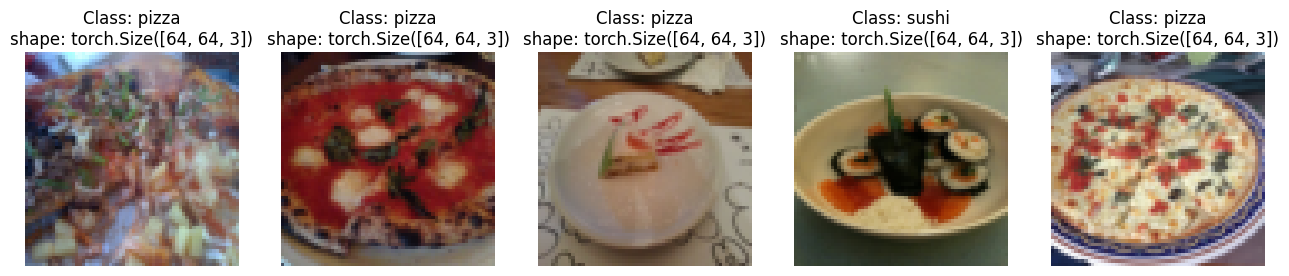

In [52]:
# Display random images from ImageFolder dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

n should not be larger than 10, setting to 10 and turning off display_shape


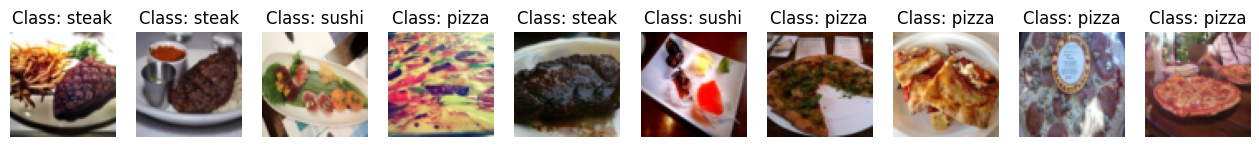

In [53]:
# Display random images from our ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

## Turn our custom dataset into `DataLoader`s (batchify)

In [54]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count(),
                                     )

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=os.cpu_count()
                                    )

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78aa1d784e20>,
 <torch.utils.data.dataloader.DataLoader at 0x78aa1d787be0>)

In [55]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [56]:
len(train_dataloader_custom) # number of batches of 32

8

## Data augmentation is the process of artificially adding diversity to training data.

In case of image data, we can apply various image transformations.

This practice hopefully results in a model to be more generalisable to unseen data

Let's take a look at one particular type of data augmentation used to train vision models to state of the art levels


In [57]:
# Lets look at one of these 'recipes' calles trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # higher the number more intense the transform, the intensity chosen is random
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


In [58]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/3530210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/320570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1654444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3821701.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1899785.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/702165.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/300869.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3018077.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/29417.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3269634.jpg')]

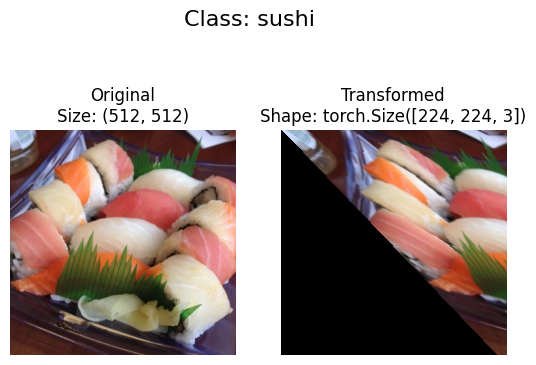

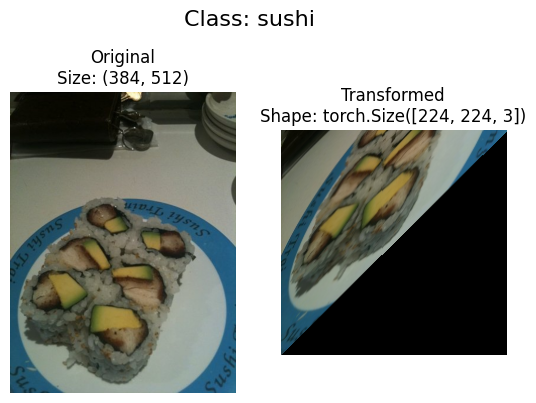

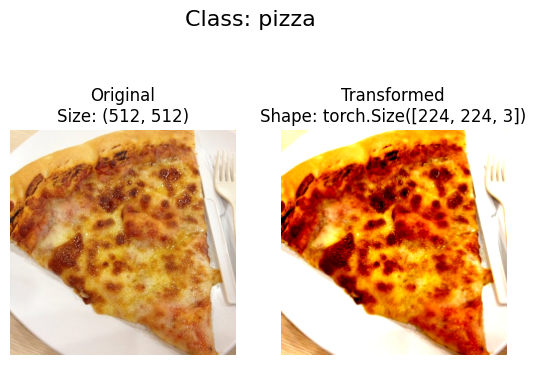

In [59]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## Model 0: TinyVGG architecture without data augmentation

### Creating transforms and loading data for Model 0

In [60]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [61]:
# Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)

# Turn datasets into dataloaders
import os
from torch.utils.data import DataLoader

# set up hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [62]:
next(iter(train_dataloader_simple))[0].shape

torch.Size([32, 3, 64, 64])

In [63]:
# Create TinyVGG model class
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # Default stride value is same as kernel size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # Default stride value is same as kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(), # turn into feature vectors
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
   # print(x.shape)
    x = self.conv_block_2(x)
   # print(x.shape)
    x = self.classifier(x)
   # print(x.shape)
    return x # you can combine all into the same line to benefit from operator fusion


In [64]:
# Random seed
torch.manual_seed(42)

# Create an instance
model_0 = TinyVGG(input_shape=3, # colour channels
                  hidden_units=10, # same as tinyvgg architecture
                  output_shape=len(class_names)
                  ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [65]:
# Try forward pass on a image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [66]:
# Try the forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

## Use `torchinfo` to get an idea of the shapes going through our model

In [67]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Creating training and testing loop
* `train_step()` takes in a model and dataloader and trains the model on the dataloader
* `test_step()` takes in a model and dataloader and evaluates the model on the dataloader

In [68]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # training mode
  model.train()

  # Set up train loss and train acc values
  train_loss, train_acc = 0, 0

  # Loop through dataloader batches
  for batch, (X, y) in enumerate(dataloader):
    # Send to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X) # Output is model logits

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # convert to label
    train_acc += (y_pred_class==y).sum().item()/len(y_pred) # summing up how many that are correct and divide by length of samples

  # Adjust metrics to get average per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [69]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # eval mode
  model.eval()

  # setup test loss and acc values
  test_loss, test_acc = 0, 0

  # inference mode
  with torch.inference_mode():
    # Loop through batchs
    for batch, (X, y) in enumerate(dataloader):
      # send to device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item() # gets the integer

      # Calculate accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    # Adjust metrics per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

### Functionalising the train() function to combine train_step() and test_step()

In [70]:
# Create train() function
from tqdm.auto import tqdm

# Create a train function that takes in many parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # Create an empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # Print out
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc {test_acc:.4f}")

    # Update results dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return results
  return results

## Train and evaluate model 0

In [71]:
# random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# Recreate instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()

# Try out adam optimizer, sgd is fine as well
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer and print out time
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0956 | Test acc 0.4492
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0830 | Test acc 0.4023
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0798 | Test acc 0.4336
Epoch: 3 | Train loss: 1.0844 | Train acc: 0.3984 | Test loss: 1.0572 | Test acc 0.5469
Epoch: 4 | Train loss: 1.0663 | Train acc: 0.4219 | Test loss: 1.0398 | Test acc 0.4453
Total training time: 11.037 seconds


In [72]:
model_0_results

{'train_loss': [1.1063192486763,
  1.0998037904500961,
  1.086868405342102,
  1.084406390786171,
  1.0662802904844284],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.421875],
 'test_loss': [1.0955813080072403,
  1.0830273479223251,
  1.0797555297613144,
  1.0572337433695793,
  1.0398017466068268],
 'test_acc': [0.44921875, 0.40234375, 0.43359375, 0.546875, 0.4453125]}

## Plotting the loss curves of Model 0

* good for tracking model's progress over time

In [73]:
# model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [74]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """ Plots training curves of a results dictionary """
  # Get loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Accuracy values
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # figure out number of epochs
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1) # row, col, idx
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot acc
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

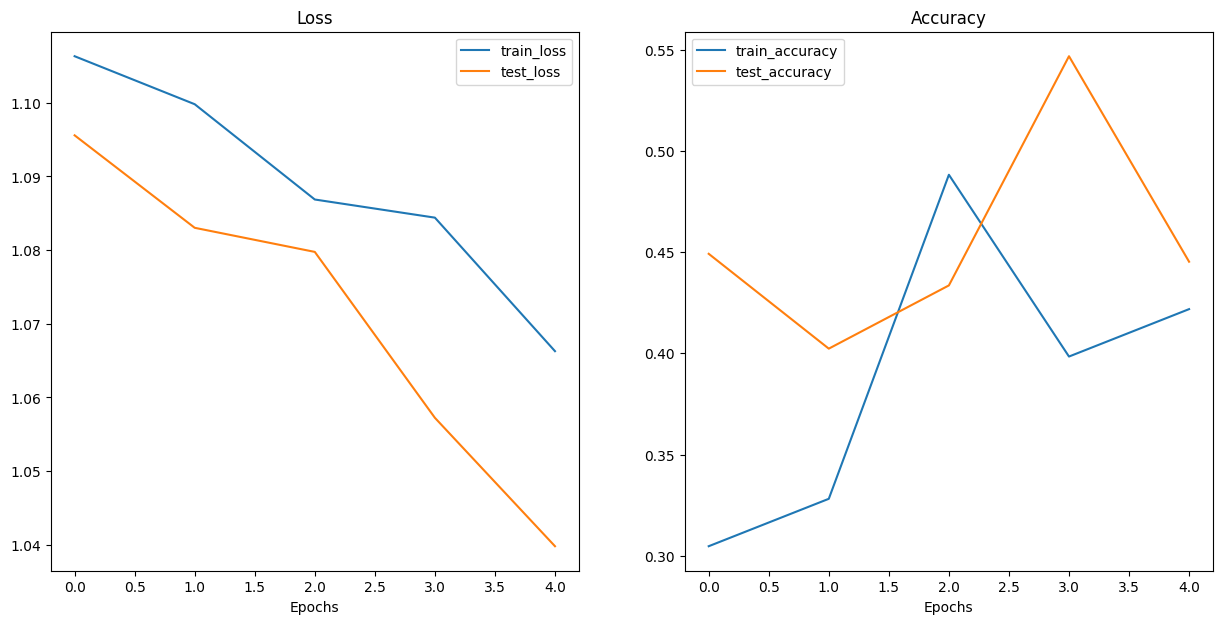

In [75]:
plot_loss_curves(model_0_results)

## What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model

* Underfitting (loss could be lower)
* Overfitting (train loss is much lower than test loss) -> model is learning training data too well but not reflected in the testing data set (memorise patterns that do not generalise well to the test data set)
* Just right (train and test loss are low and close to each other), training loss may still be slightly lower as the model is learning from them


To solve these:
* Overfitting (get more data, data augmentation, use better data samples,
simplify model by reducing hidden layers/units etc, use learning rate decay by lower learning rate the closer you get to convergence, stop training once you see the testing error starts increasing for maybe a few steps)

* Underfitting (add more hidden layers/units, tweak learning rate, increase the number of epochs/data, use less regularisation)

## Model 1: TinyVGG with Data Augmentation
Try using the same model but with data augmentation

In [76]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # only for training data set
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

## Create train and test datasets and dataloaders with data augmentation

In [77]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [78]:
# Turn datasets into dataloaders

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

## Create and train model 1

This time we will be using same model architecture but the training data is augmented


In [79]:
# Create model_1 and send to target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Create loss function and optimizer and call upon train() function

In [80]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# epochs
NUM_EPOCHS = 5

# loss function (also known as criterion)
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End timer
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1260 | Test acc 0.2604
Epoch: 2 | Train loss: 1.0713 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc 0.2604
Epoch: 3 | Train loss: 1.1259 | Train acc: 0.3047 | Test loss: 1.1583 | Test acc 0.2604
Epoch: 4 | Train loss: 1.0859 | Train acc: 0.4219 | Test loss: 1.1553 | Test acc 0.3125
Total training time for model_1: 7.510 seconds


### Plot loss curves of model 1 now

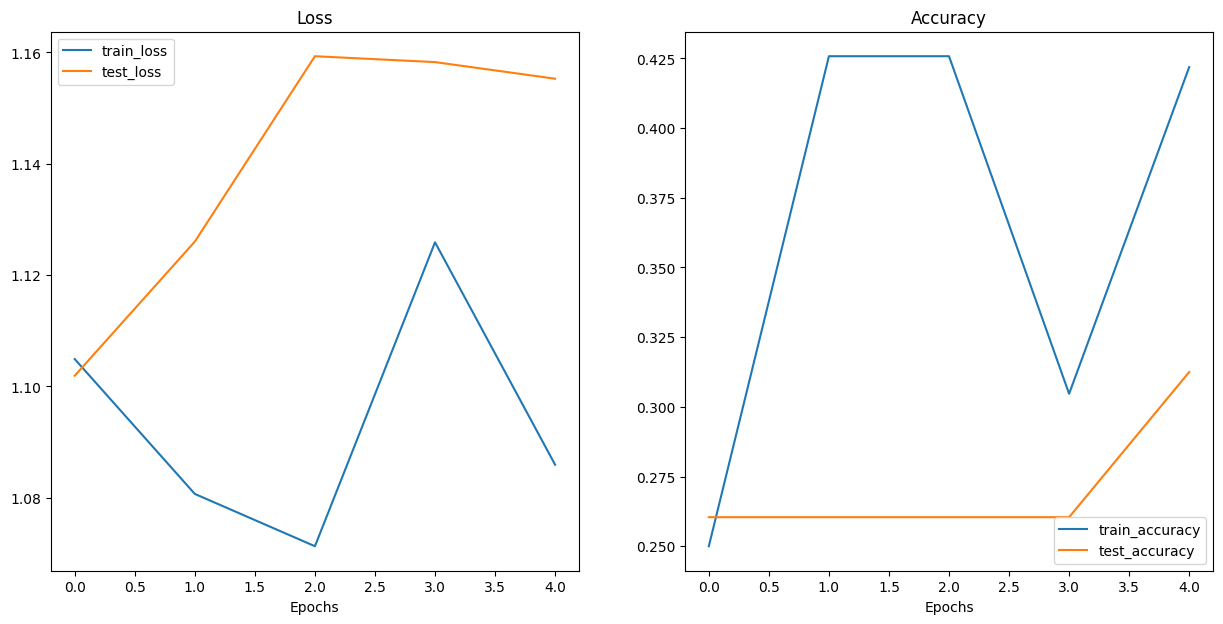

In [81]:
plot_loss_curves(model_1_results)

# Seems like our model is both underfitting and overfitting

## Compare model results to each other

After evaluating the modelling experiments must compare them to each other, a few ways to do this:

1. Hard coding (just like what we did to make functions)
2. Tools (
  `torch.utils.tensorboard`, Weights & biases, MLflow )


In [82]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)


In [83]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.095581,0.449219
1,1.099804,0.328125,1.083027,0.402344
2,1.086868,0.488281,1.079756,0.433594
3,1.084406,0.398438,1.057234,0.546875
4,1.066280,0.421875,1.039802,0.445312


In [84]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104914,0.250000,1.101927,0.260417
1,1.080687,0.425781,1.126024,0.260417
2,1.071292,0.425781,1.159328,0.260417
3,1.125898,0.304688,1.158272,0.260417
4,1.085936,0.421875,1.155287,0.312500


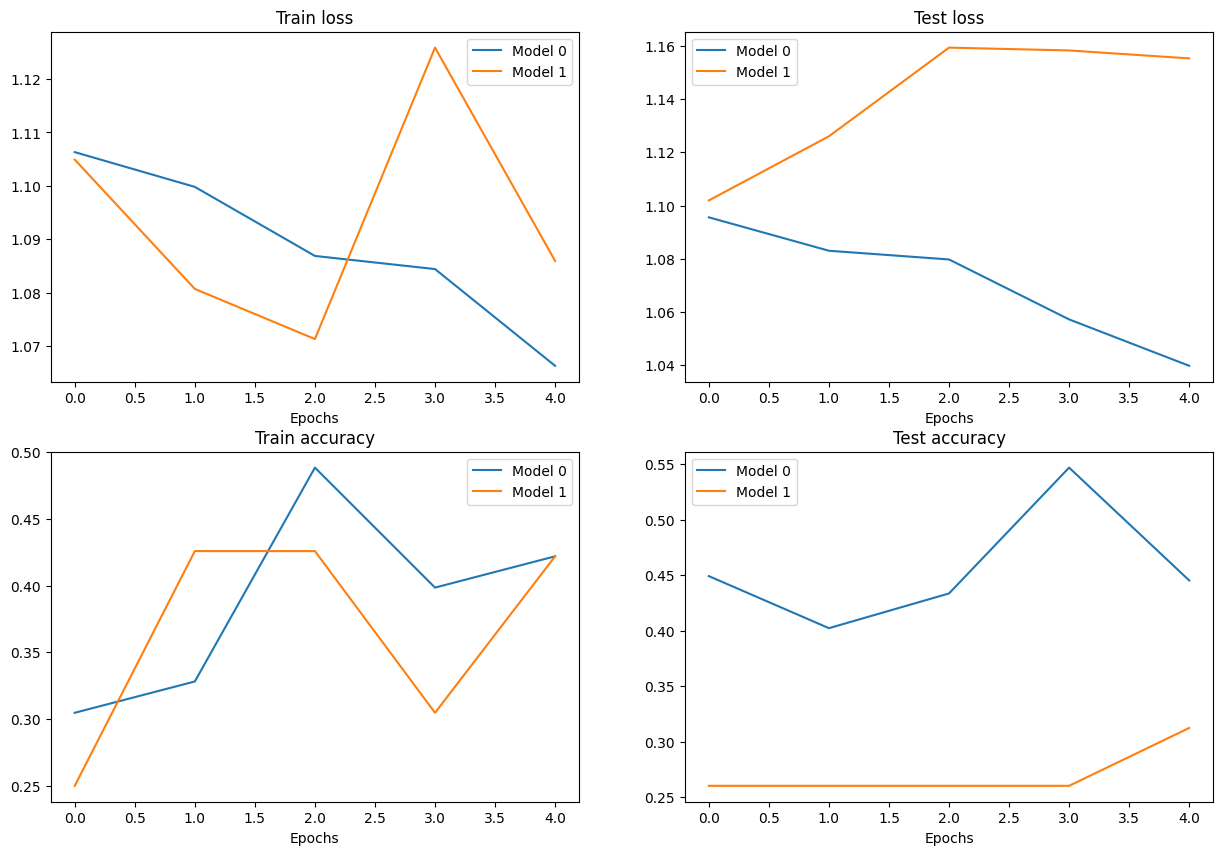

In [85]:
# Plot them against each other
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df)) # so axis is a range

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend();

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend();

## How to make prediction on sample image that is not on training/testing dataset

In [104]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if doesnt exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download the raw link from GitHub
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exists, skipping download...")

data/04-pizza-dad.jpeg already exists, skipping download...


## Need to ensure the custom image is in the same format as the data our model was trained on

* tensor form, float32
* shape 64,64,3
* device

We can read an image into PyTorch

In [105]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [106]:
str(custom_image_path)

'data/04-pizza-dad.jpeg'

In [110]:
import torchvision

# Read custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

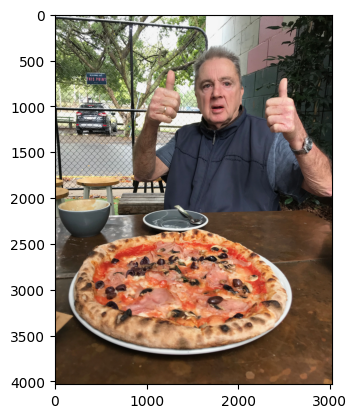

In [109]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

##  Making prediction on custom image with a model

In [112]:
# Convert to torch.float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255 # colours for RGB are in 0 to 255 so we scale them back to 0 to 1

In [115]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform
custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


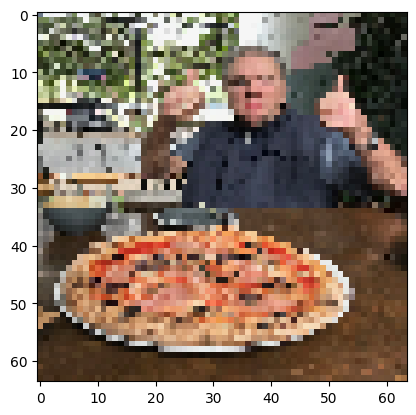

In [118]:
plt.imshow(custom_image_transformed.permute(1, 2, 0)); # far lower quality

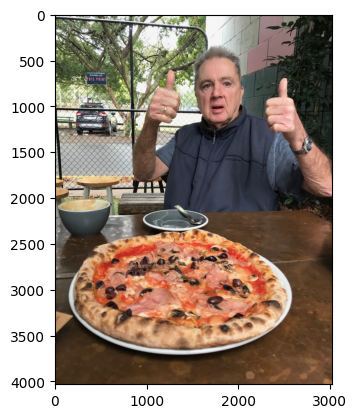

In [119]:
# original
plt.imshow(custom_image.permute(1, 2, 0));

In [121]:
# Move to device, make a batch dimension and try making prediction on an image
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [122]:
custom_image_pred

tensor([[ 0.0708,  0.0491, -0.2032]], device='cuda:0')

In [124]:
class_names

['pizza', 'steak', 'sushi']

In [127]:
# Convert logits to pred probs

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1) # multi class classification
custom_image_pred_probs # 0 to 1

tensor([[0.3651, 0.3573, 0.2776]], device='cuda:0')

In [134]:
# Convert pred probs to pred labels

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [135]:
class_names[custom_image_pred_label]

'pizza'

## Putting custom image prediction together by building a function

* Pass an image path to and have model predict on that image and plot image + prediction label

In [146]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """ Makes a prediction on a target image with a trained model and plots
  the image and prediction """

  # Load image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between 0 and 1
  target_image /= 255

  # Transform data if necesssary
  if transform:
    target_image = transform(target_image)

  # Make sure model is on target device
  model.to(device)

  # Make prediction
  model.eval()
  with torch.inference_mode():
    # Add extra dimension for batch dimension
    target_image = target_image.unsqueeze(0)

    # Make prediction on image
    target_image_pred = model(target_image.to(device)) # make sure target image on right device

  # convert logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # convert prediction probabilities to pred labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image with prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dim and get H,W,C
  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}" # matplotlib cannot handle data on gpu
  else:
    title = f"Pred: {target_image_pred_labels} | Prob:{target_image_pred_probs.max.cpu():.3f}"

  plt.title(title)
  plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


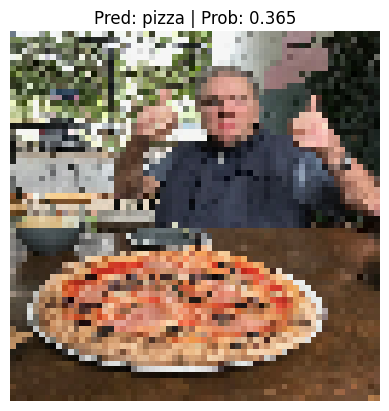

In [148]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)